<a href="https://colab.research.google.com/github/Salma-Jamal/MedicalToolsSegmentation-/blob/main/Medical_tools_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Tools Segmentation

## Problem Description
A segmentation problem using the U-Net architecture.

https://www.kaggle.com/datasets/aithammadiabdellatif/binarysegmentation-endovis-17?select=BinarySegmentation


## Imports

In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4
!pip install torchtext==0.1.1

In [ ]:
# Restrat runtime before importing
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pprint import pprint
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

---
## 1.Data Exploration and Preprocessing
To preprocess the data, follow these steps:
1. Load the dataset and explore it
2. Resize the images and masks to a fixed size.
3. Normalize the image data.
4. Apply data augmentation techniques to increase the dataset size (if needed). You can use libraries like Albumentations for augmentation.
5. Split The data to train and test
---

### Download Data

In [ ]:
# upload your kaggle.json API file before runnig this cell
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aithammadiabdellatif/binarysegmentation-endovis-17
!unzip /content/binarysegmentation-endovis-17.zip -d Data

### Explore Dataset

In [ ]:
bin_image_dir = '/content/Data/BinarySegmentation/images'
bin_mask_dir = '/content/Data/BinarySegmentation/binary_masks'

In [ ]:
def visualize_data(image_dir, mask_dir, samples):
  """
  Visualize a sample of images and their corresponding masks from the given directories.

  Parameters:
      image_dir (str): The directory path containing the image files.
      mask_dir (str): The directory path containing the mask files.
      samples (int): The number of samples to visualize.

  Returns:
      None

  """
  image_files = sorted(os.listdir(image_dir))
  mask_files = sorted(os.listdir(mask_dir))

  fig, axs = plt.subplots(samples, 2, figsize=(8, 2 * samples))
  for i, (image_file, mask_file) in enumerate(zip(image_files[:samples], mask_files[:samples])):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Image {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Mask {i+1}")
    axs[i, 1].axis('off')

  plt.tight_layout()
  plt.show()


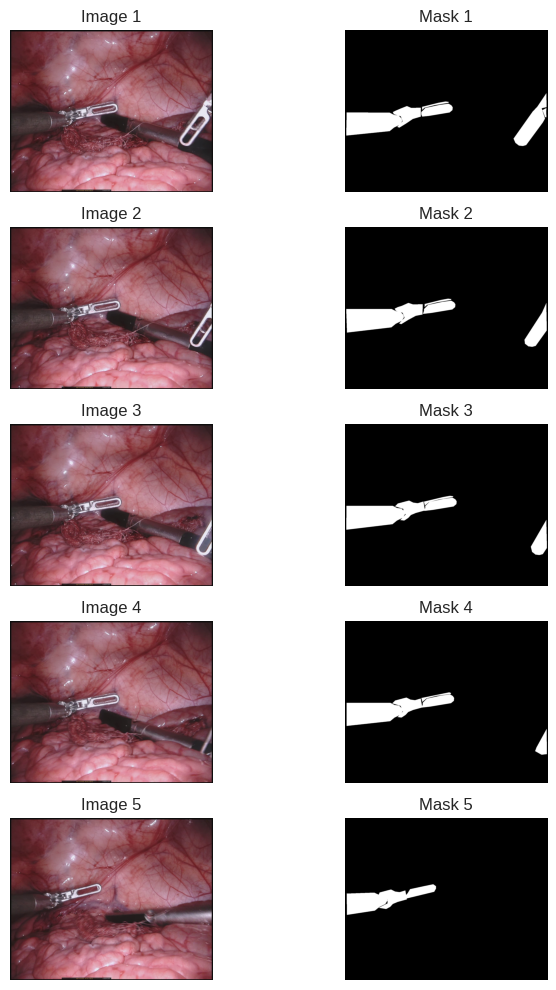

In [ ]:
visualize_data(bin_image_dir,bin_mask_dir,5)

### Preprocess & Split Dataset

In [ ]:
# Augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
])

In [ ]:
def preprocess_data(image_dir, mask_dir,image_shape,Augment_images=False):
  """
      Preprocesses and prepare the images and masks from a given directories.

      Parameters:
          image_dir (str): The directory path containing the image files.
          mask_dir (str): The directory path containing the mask files.
          image_shape (tuple): The desired shape to which images and masks will be resized.
          Augment_images (bool): If True, applies data augmentation to the images and masks.

      Returns:
          tuple: A tuple containing torch tensors of train_images, train_masks, valid_images, valid_masks,
          test_images, and test_masks respectively.
  """


  sorted_images = sorted(os.listdir(image_dir))
  sorted_masks = sorted(os.listdir(mask_dir))

  images = []
  masks = []
  for image_file, mask_file in zip(sorted_images, sorted_masks):
      image_path = os.path.join(image_dir, image_file)
      mask_path = os.path.join(mask_dir, mask_file)

      # Read Image
      image = cv2.imread(image_path)
      mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

      # Read resize
      image = cv2.resize(image, image_shape)
      mask = cv2.resize(mask, image_shape)

      # Normalize
      image = image / 255.0
      mask = np.where(mask > 0, 1.0, mask)

      # Apply Augmentation
      if Augment_images:
        augmented = transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

      image = image.transpose((2, 0, 1))
      mask = mask[np.newaxis, :, :]


      images.append(image)
      masks.append(mask)

  images = np.array(images)
  masks = np.array(masks)

  images = torch.tensor(images, dtype=torch.float32).to('cuda')
  masks = torch.tensor(masks, dtype=torch.float32).to('cuda')

  # Split Data into training, testing and validation
  train_images, test_images, train_masks, test_masks = train_test_split(
      images, masks, test_size=0.2, random_state=42
  )

  test_images, valid_images, test_masks, valid_masks = train_test_split(
      test_images, test_masks, test_size=0.5, random_state=42
  )

  return  train_images, train_masks, valid_images,valid_masks,test_images,test_masks

In [ ]:
image_shape = (256,256)
train_images, train_masks, valid_images,valid_masks,test_images,test_masks = preprocess_data(bin_image_dir, bin_mask_dir,
                                                                                             image_shape,Augment_images=True)

In [ ]:
print(f"Train data size {len(train_images)}\nValid data size {len(valid_images)}\nTest data size {len(test_images)}")

Train data size 420
Valid data size 53
Test data size 52


___
## 2.U-Net Architecture
You have two options for implementing the U-Net architecture to choose from :<br>
- Build the U-Net from scratch.<br>
- Use a pre-built implementation from TensorFlow , PyTorch or any python packges that provide the model.<br>
---

###2.1 Building U-Net Model <specify the implementaion  option here>
Your code implementation for the U-Net architecture should go here.

https://github.com/qubvel/segmentation_models.pytorch/tree/master


In [ ]:
class SurgeryToolsModel(pl.LightningModule):
    """
      PyTorch Lightning module for a segmentation model on Surgery Tools dataset.

      Parameters:
          arch (str): Model architecture name.
          encoder_name (str): Encoder name used in the segmentation model.
          in_channels (int): Number of input channels for the model.
          out_classes (int): Number of output classes for the model.
          **kwargs: Additional keyword arguments to be passed to the segmentation model.

      Attributes:
          model: Segmentation model created using the specified architecture and encoder.
          std (torch.Tensor): Tensor containing standard deviation used for image normalization.
          mean (torch.Tensor): Tensor containing mean used for image normalization.
          loss_fn: Dice Loss function used for training the model.

    """

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # dice loss
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def update_log_file(self, stage,loss,per_image_iou,dataset_iou):
        log_file_path = "log_file.txt"
        with open(log_file_path, "a") as log_file:
            log_file.write(f"Stage:{stage}, Loss: {loss}, per_image_iou: {per_image_iou}, dataset_iou: {dataset_iou}\n")


    def shared_step(self, batch, stage):
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be (batch_size, num_classes, height, width)
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        loss = self.loss_fn(logits_mask, mask)

        # compute metrics
        # Convert mask values to probabilities
        prob_mask = logits_mask.sigmoid()
        # Apply thresholding
        pred_mask = (prob_mask > 0.5).float()

        # Compute IoU metric
        # Compute true positive, false positive, false negative and true negative 'pixels' for each image and class
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU: Calculate IoU score for each image then compute mean over these scores.
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU: Aggregate intersection and union over whole dataset then compute IoU score.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        self.update_log_file(stage,outputs[0]['loss'].item(),per_image_iou.item(),dataset_iou.item())

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = SurgeryToolsModel("unetplusplus", "resnet18", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


### 2.2 Compile the model with an appropriate loss function and optimizer.

---
## 3.Model Training
To train the U-Net model, do the following:
1. Set hyperparameters like the number of epochs and batch size.
2. Monitor the training progress (e.g., print loss values , use callbacks or plot the acc vs loss graphs ).
3. Save the best wieghtto use  in the evaluation part
---

### Initialize Hyperparameters

In [ ]:
epochs=10
batch_size = 32

In [ ]:
train_dataset = torch.utils.data.TensorDataset(train_images, train_masks)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(valid_images, valid_masks)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(test_images, test_masks)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="Best_checkpoint",
    filename="best_model",
    monitor="valid_dataset_iou",
    mode="max",
    save_top_k=1
)

In [ ]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=epochs,
    log_every_n_steps= 14,
    callbacks=[checkpoint_callback]
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


### Training

In [ ]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 16.0 M
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
16.0 M    Trainable params
0         Non-trainable params
16.0 M    Total params
63.882    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Validation

In [ ]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.7770509719848633,
  'valid_per_image_iou': 0.7560858130455017}]


### Visualise Training and Validation Matrices

#### Extract values from log file

In [ ]:
log_file_path = "/content/log_file.txt"
data = []
with open(log_file_path, "r") as log_file:
    for line in log_file:
        stage, loss, per_image_iou, dataset_iou = line.strip().split(", ")
        loss = float(loss.split(": ")[1])
        per_image_iou = float(per_image_iou.split(": ")[1])
        dataset_iou = float(dataset_iou.split(": ")[1])
        stage= stage.split(':')[1]
        data.append({"Stage": stage, "Loss": loss, "Per_Image_IOU": per_image_iou, "Dataset_IOU": dataset_iou})

df = pd.DataFrame(data)

#### Training & Validation Loss Plot

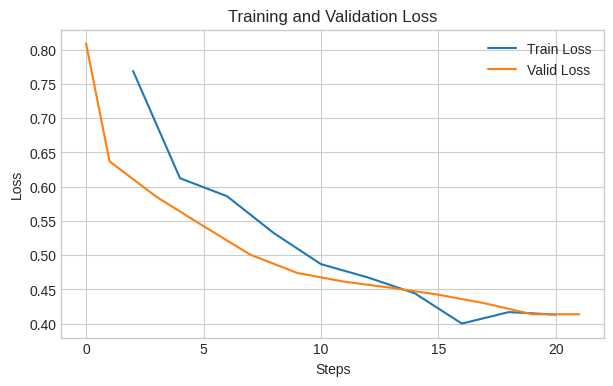

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(df[df["Stage"] == "train"].index, df[df["Stage"] == "train"]["Loss"], label="Train Loss")
plt.plot(df[df["Stage"] == "valid"].index, df[df["Stage"] == "valid"]["Loss"], label="Valid Loss")


plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()

#### Training and Validation Per_Image_IOU & Dataset_IOU

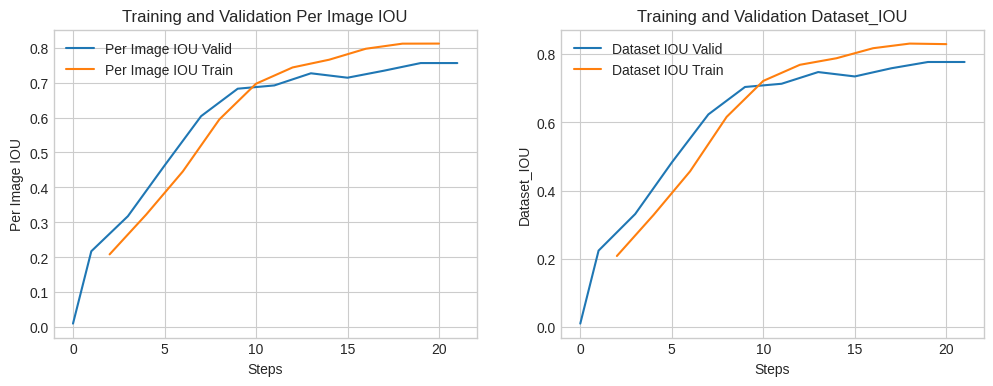

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))


axs[0].plot(df[df["Stage"] == "valid"].index, df[df["Stage"] == "valid"]["Per_Image_IOU"], label="Per Image IOU Valid")
axs[0].plot(df[df["Stage"] == "train"].index, df[df["Stage"] == "train"]["Per_Image_IOU"], label="Per Image IOU Train")
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Per Image IOU")
axs[0].set_title("Training and Validation Per Image IOU")
axs[0].legend()
axs[0].grid(True)


axs[1].plot(df[df["Stage"] == "valid"].index, df[df["Stage"] == "valid"]["Dataset_IOU"], label="Dataset IOU Valid")
axs[1].plot(df[df["Stage"] == "train"].index, df[df["Stage"] == "train"]["Dataset_IOU"], label="Dataset IOU Train")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Dataset_IOU")
axs[1].set_title("Training and Validation Dataset_IOU")
axs[1].legend()
axs[1].grid(True)


plt.show()

---
## 4.Model Evaluation
Evaluate the trained model on a separate test dataset using the following steps:
1. Calculate relevant metrics such as Dice coefficient or IoU.
2. Visualize the segmentation results .
---

### Load model checkpoint

In [ ]:
checkpoint_path = '/content/Best_checkpoint/best_model.ckpt'
checkpoint = torch.load(checkpoint_path)
model = SurgeryToolsModel("unetplusplus", "resnet18", in_channels=3, out_classes=1)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Testing

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.791693389415741,
  'test_per_image_iou': 0.7655736207962036}]


### Visualize the Segmentation Results

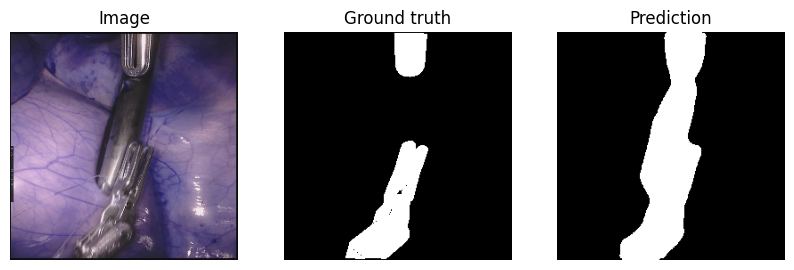

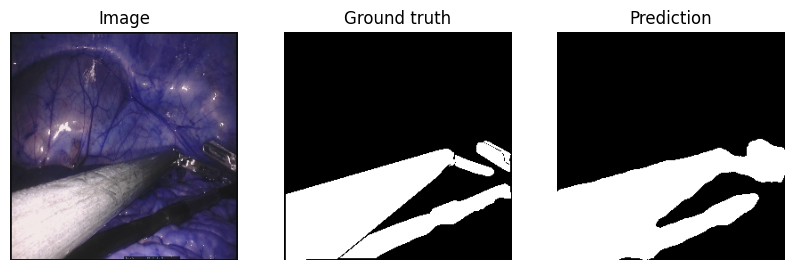

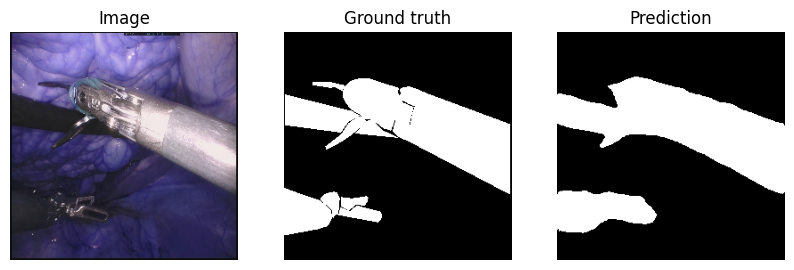

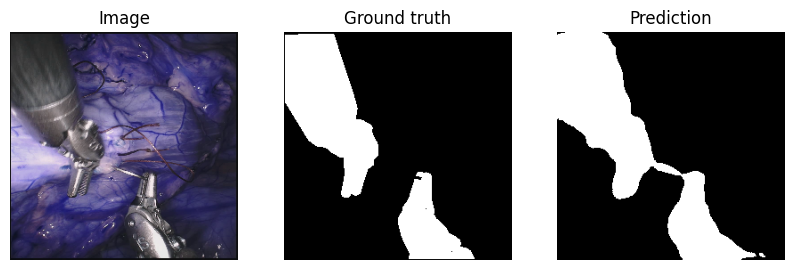

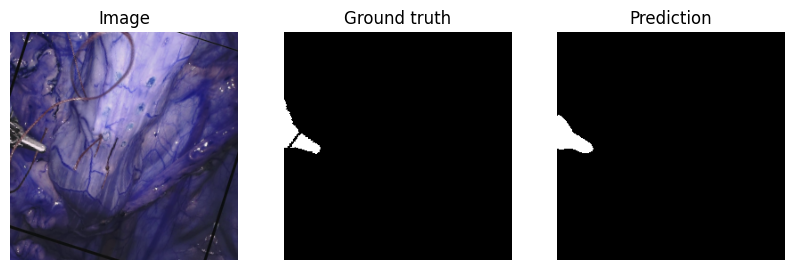

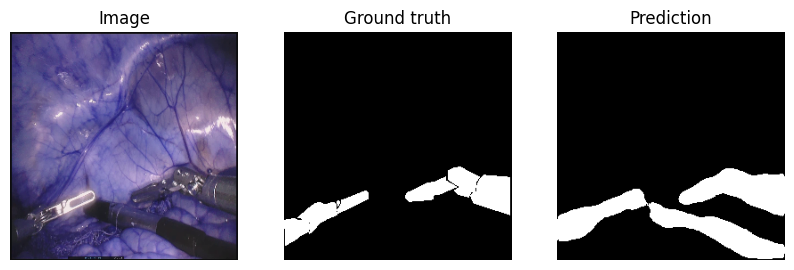

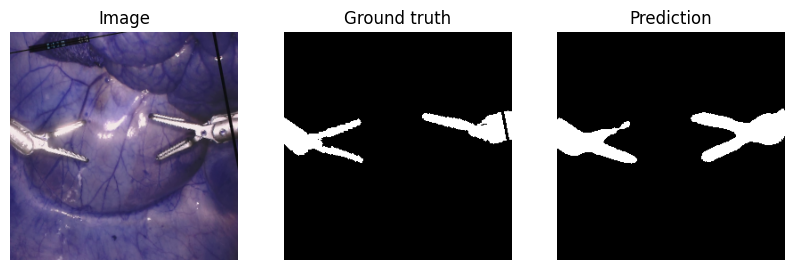

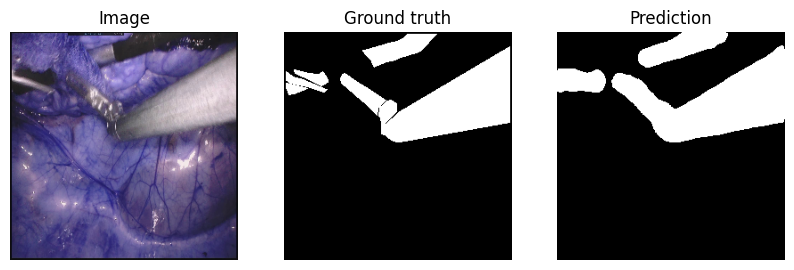

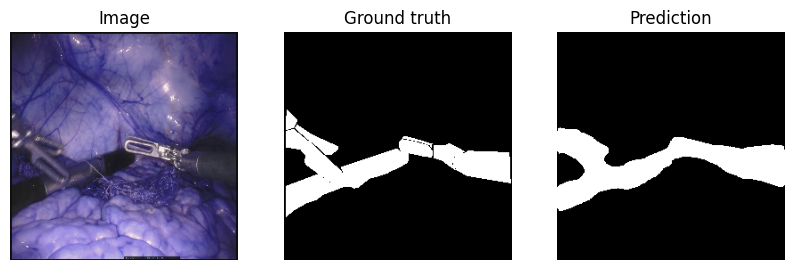

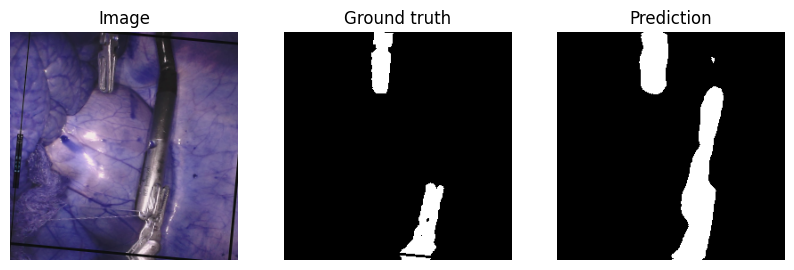

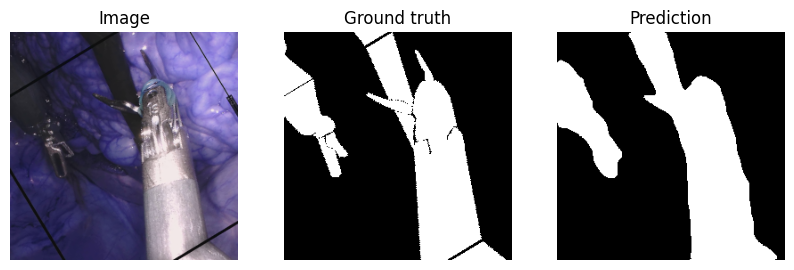

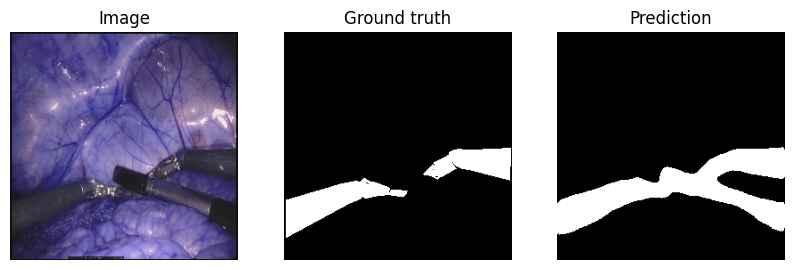

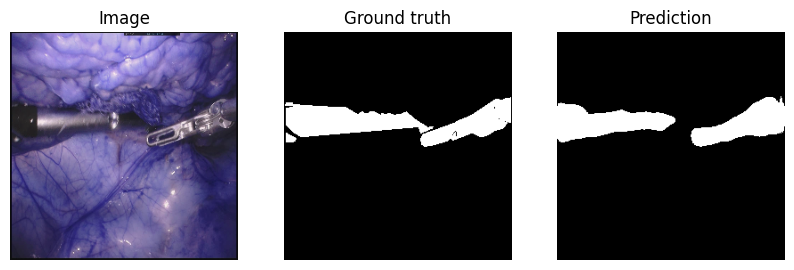

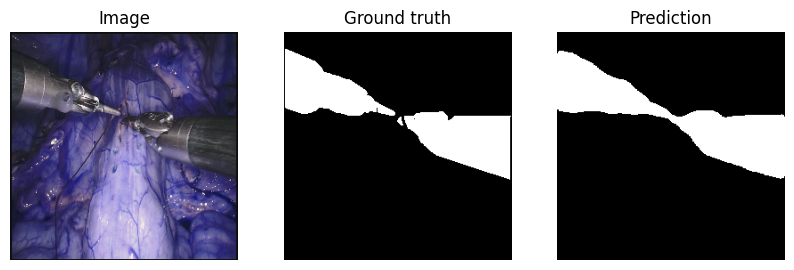

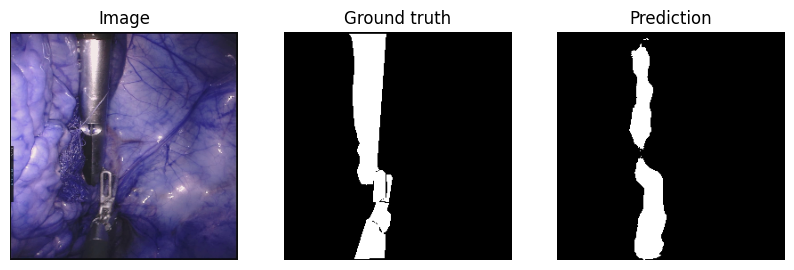

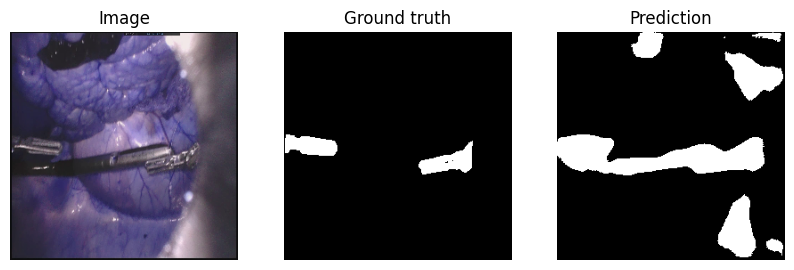

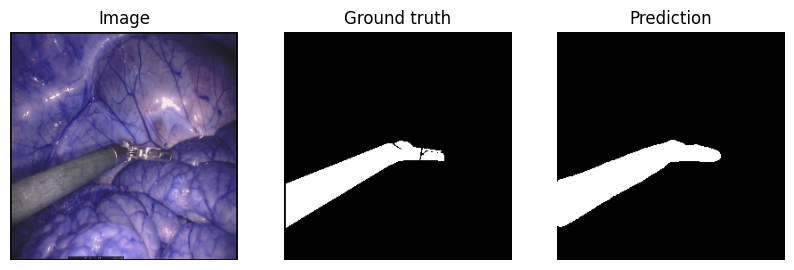

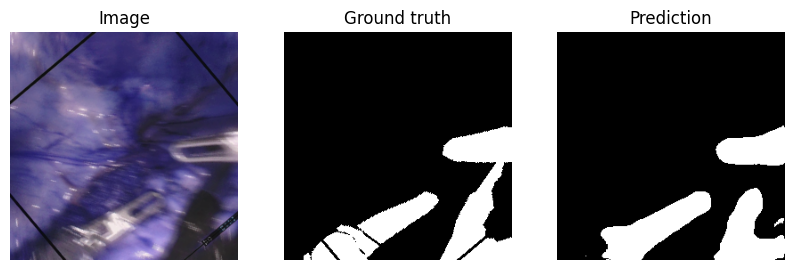

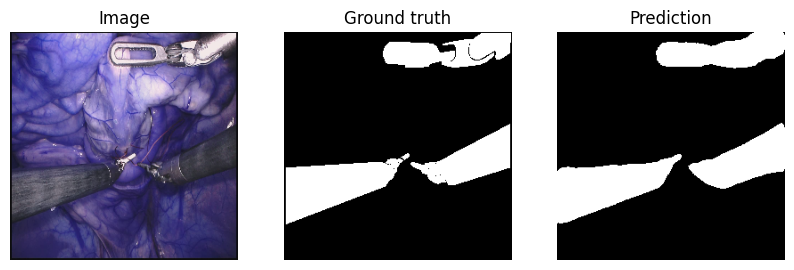

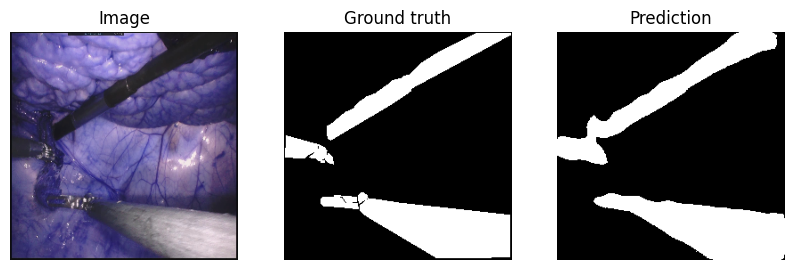

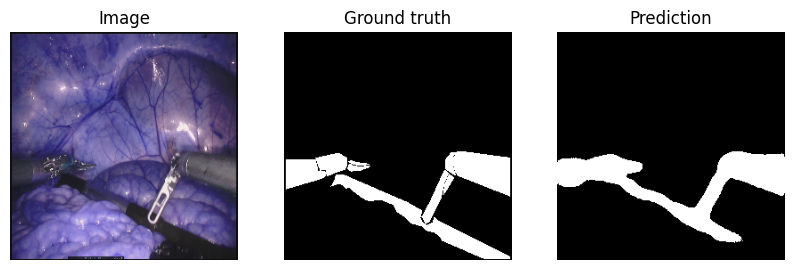

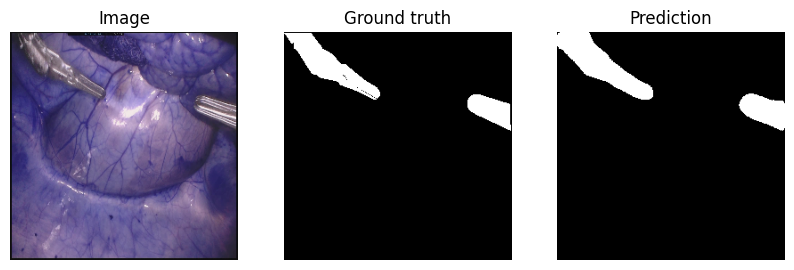

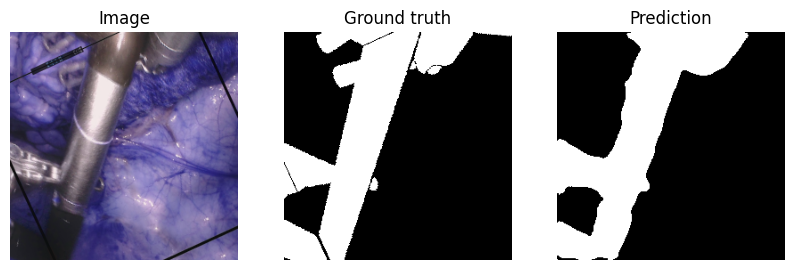

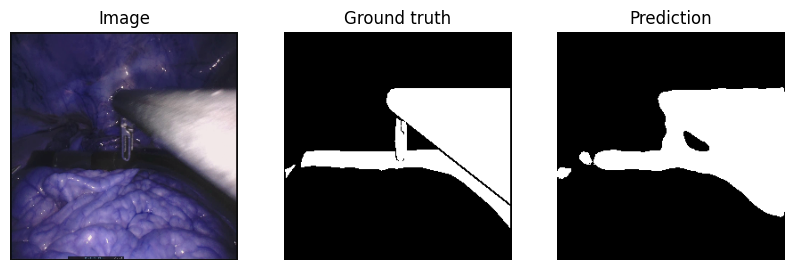

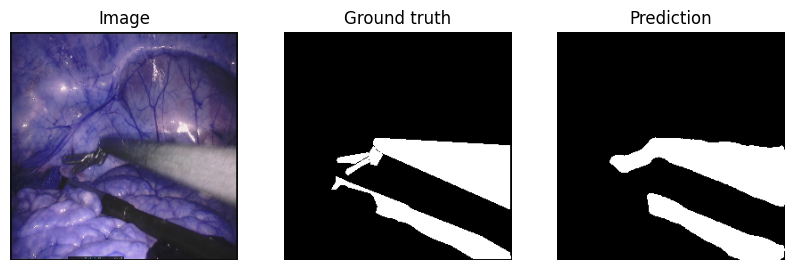

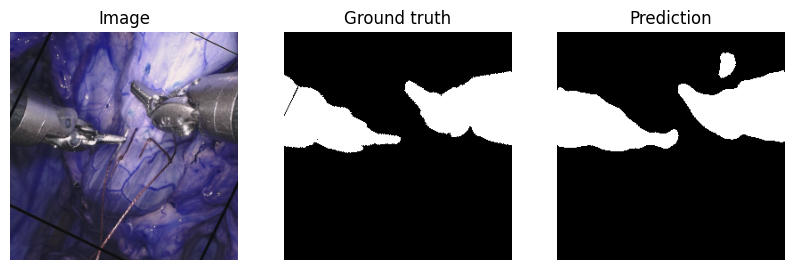

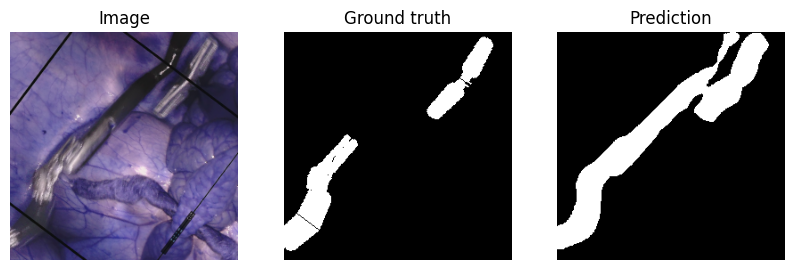

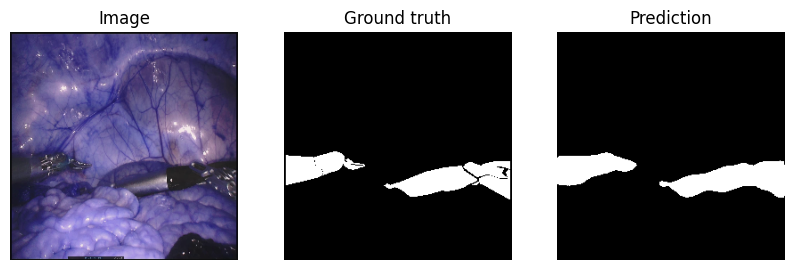

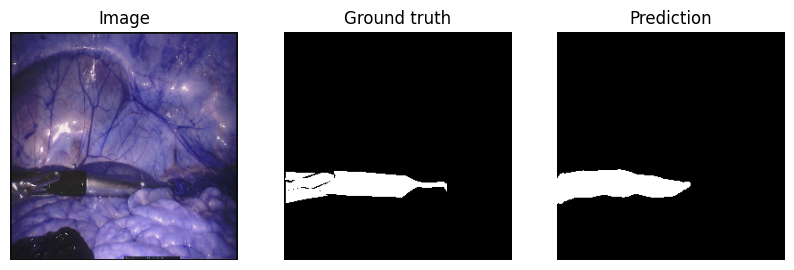

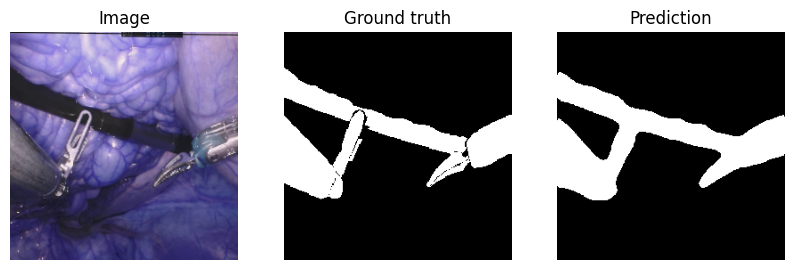

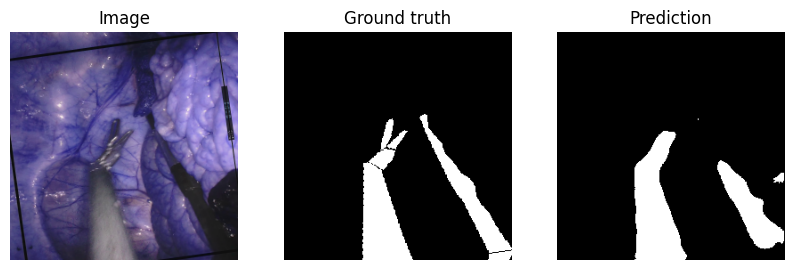

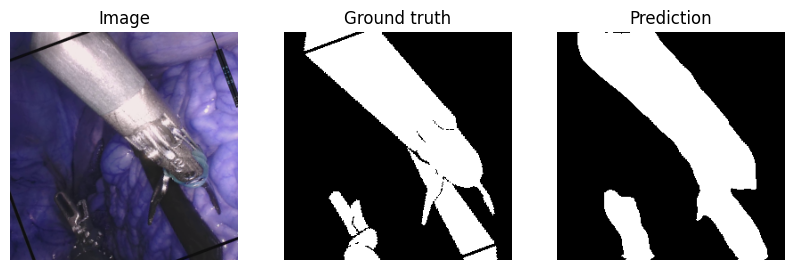

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to('cpu'))
pr_masks = logits.sigmoid()
pr_masks = (pr_masks > 0.5).float()
plt.style.use('default')
for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.to('cpu').numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.to('cpu').numpy().squeeze(), cmap='gray') # squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.to('cpu').numpy().squeeze(), cmap='gray') # squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()